### I- Libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk

# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import contractions
from collections import defaultdict
import re
import string
from textblob import TextBlob
from spellchecker import SpellChecker
from sklearn.preprocessing import LabelEncoder



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### II- Data importation

In [ ]:
traitDataset = pd.read_csv("mbti_1.csv")

### III- Data visualization

#### III-1 General look to our dataset

In [ ]:
traitDataset.shape

(8675, 2)

In [ ]:
traitDataset.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


#### III-2 Looking NAs

In [ ]:
traitDataset.isnull().sum()

type     0
posts    0
dtype: int64

#### III-3 Target class distribution

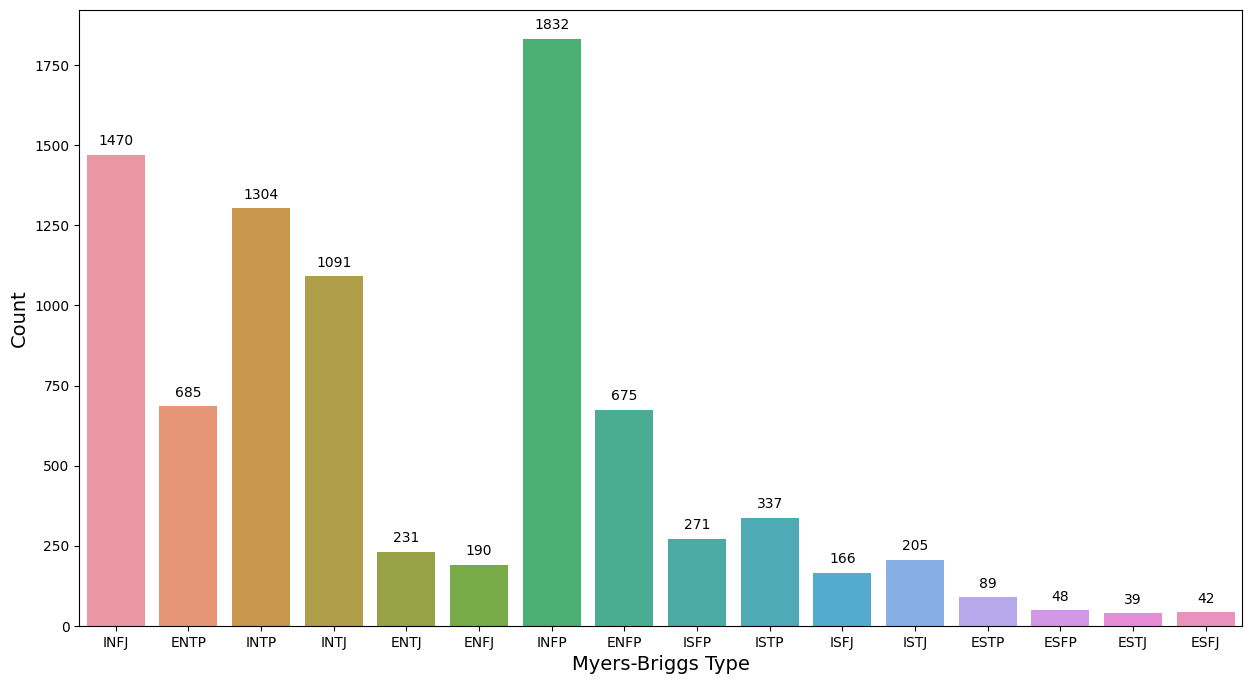

In [ ]:
plt.figure(figsize = (15,8))
ax = sns.countplot(x = 'type', data = traitDataset)
ax.set_xlabel("Myers-Briggs Type", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

# add count of each column to the column
for pxs in ax.patches:
    ax.annotate(format(pxs.get_height(), '.0f'),
                (pxs.get_x() + pxs.get_width() / 2., pxs.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# WordCLOUD

<ipython-input-9-ff93aca6b077>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,k+1)


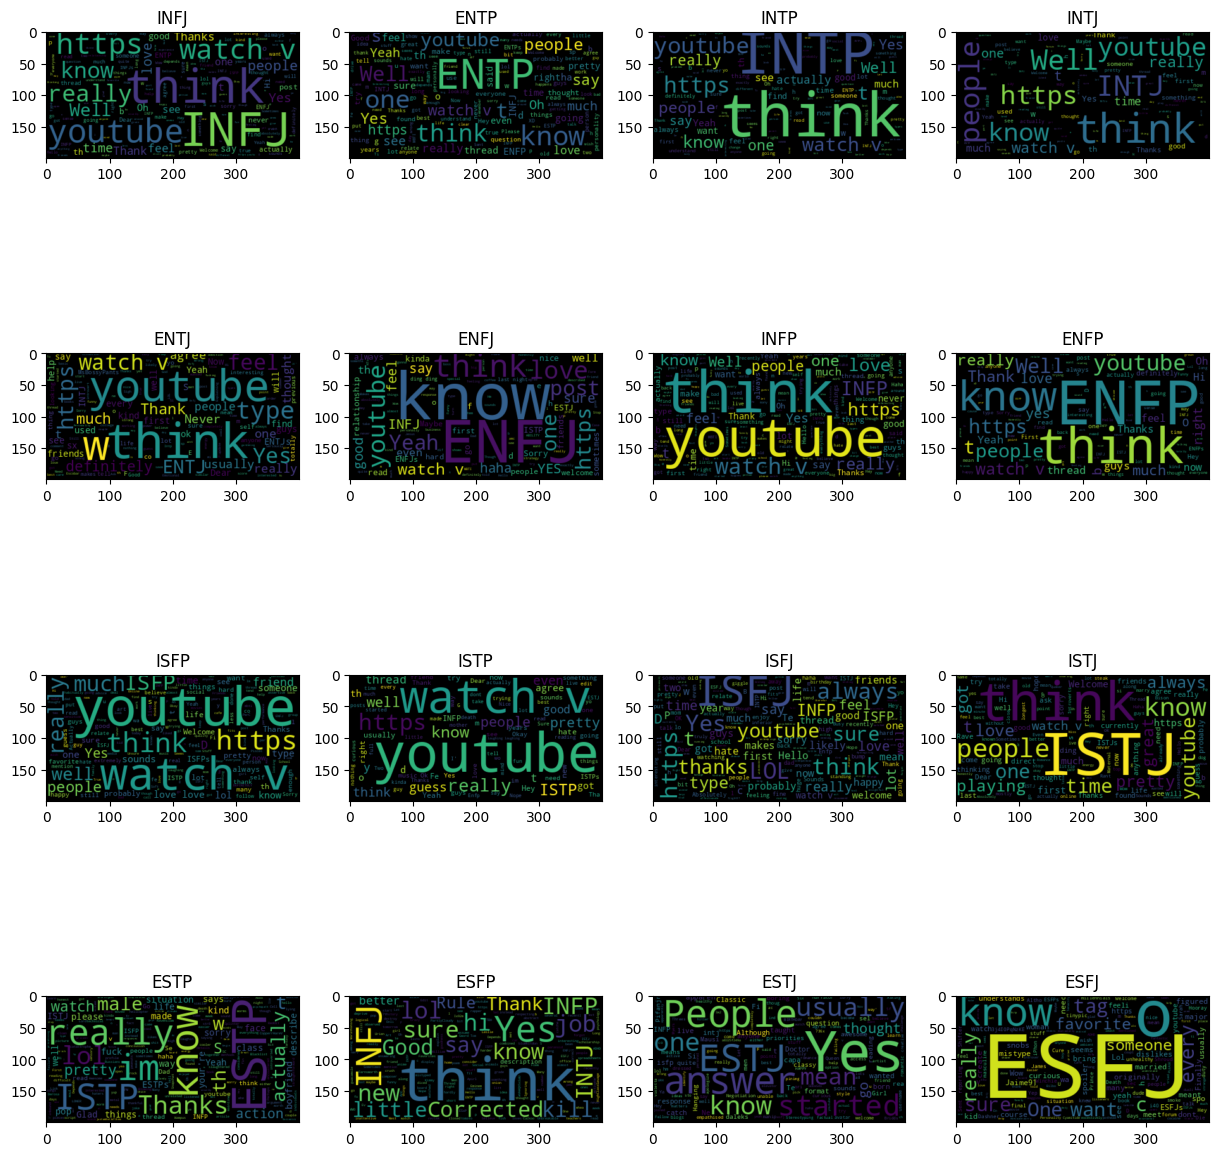

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(traitDataset['type'].unique()), sharex=True, figsize=(15,len(traitDataset['type'].unique())))

k = 0
for i in traitDataset['type'].unique():
    df_4 = traitDataset[traitDataset['type'] == i]
    wordcloud = WordCloud(max_words=1628, relative_scaling=1, normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k += 1

plt.show()

splitting data and Stratify split to ensure equal distribution of data

In [ ]:
train_data,test_data=train_test_split(traitDataset,test_size=0.2,random_state=42,stratify=traitDataset.type)

#### III-4 Stopping words

In [ ]:
def common_symb(target):
    common_symb_list=[]
    for x in traitDataset[traitDataset['type']==target]['posts'].str.split():
        for i in x:
            common_symb_list.append(i)
    return common_symb_list

common_symb_list_dis = common_symb("INFJ") 
    
def common_word(common_word_list):
    stop_words = stopwords.words('english')
    words_dict = defaultdict(int)
    for word in common_word_list:
        if word in stop_words:
            words_dict[word]+=1
    # Descending order sort "words_dict" and return the top 10 items
    top_words=sorted(words_dict.items(), key=lambda x:x[1],reverse=True)[:10] 
    
    # Separate keys and values
    x,y=zip(*top_words)

    # Making the bar chart on the data

    plt.bar(x,y)

    # Giving title to the plot
    plt.title("Stopping words frequency.")
        
    # Giving X and Y labels
    plt.xlabel("Words")
    plt.ylabel("Frequency")

    plt.show()
    return top_words


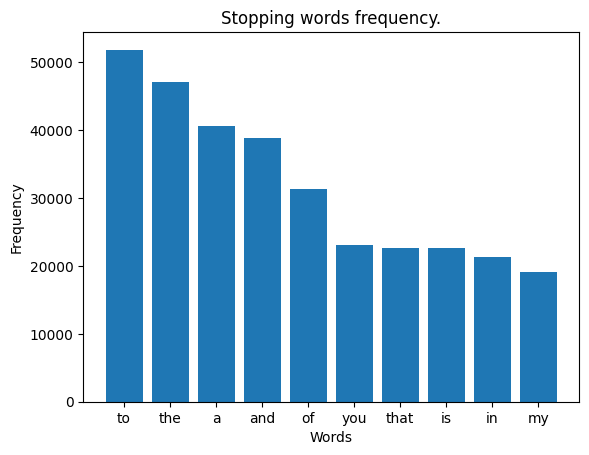

[('to', 51831),
 ('the', 47049),
 ('a', 40577),
 ('and', 38888),
 ('of', 31386),
 ('you', 23143),
 ('that', 22691),
 ('is', 22679),
 ('in', 21375),
 ('my', 19098)]

In [ ]:
common_word(common_symb_list_dis)

### III- Data preprocessing and cleaning

#### III-1 lower casing the text 

In [ ]:
def lower_text(text):
    return text.lower()

#### III-2 Removing Myers briggs types from the posts
since posts has myers briggs types on  them, it would be better to remove them from the posts so as they don't interfere in the prediction and so as our model performs better on unseen data.

Let's first check if they exist or not.

In [ ]:
personality_types = traitDataset['type'].unique()

personality_types_hashmap = {}
# a function to check if personality_types are in the posts or not and print the occurences of them.
def check_personality_types(personality_types):
    for personality_type in personality_types:
        personality_types_hashmap[personality_type] = traitDataset[traitDataset['posts'].str.contains(personality_type)]['type'].count()
    
    return(personality_types_hashmap)
    

check_personality_types(personality_types)

{'INFJ': 3850,
 'ENTP': 2697,
 'INTP': 3701,
 'INTJ': 4024,
 'ENTJ': 2003,
 'ENFJ': 1983,
 'INFP': 4272,
 'ENFP': 3231,
 'ISFP': 1793,
 'ISTP': 1819,
 'ISFJ': 1847,
 'ISTJ': 2146,
 'ESTP': 1589,
 'ESFP': 1601,
 'ESTJ': 1472,
 'ESFJ': 1657}

In [ ]:
# function to remove ersonality_personality_types words from traitDataset function
def remove_personality_personality_types_words(text):
    for personality_type in personality_types:
        text = text.replace(personality_type, '')
    return text.strip()

#### III-4 Checking and removing URLs

First we must check if our data has urls in it or not.

In [ ]:
def has_url(text):
        # define the regular expression pattern
        url_pattern = re.compile('https?://[^\s<>"]+|www\.[^\s<>"]+')
        
        # check if the pattern matches the text
        if url_pattern.search(text):
            return True
        else:
            return False
        
def count_urls(df, column):
    count = 0
    for row in df[column]:
        if has_url(row):
            count += 1
        else:
            continue
            
    return count
count_urls(traitDataset, 'posts')

5555

Since our posts column has urls in it, we must remove them. Since they are not required for our natural language processing. They don't really contribute to the meaning of the posts. "Maybe in an other advanced research yes"

- Let's create a function to remove them

In [ ]:
def remove_links_and_symbols(text):
    # Removing links from text data
    text = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+', ' ', text)
    
    # Removing other non-alphanumeric symbols
    text = re.sub('[^0-9a-z]', ' ', text)

    return text

#### III-6 Looking for emojis and removing them

In [ ]:
def has_emojis(text):
        # define the regular expression pattern
        emojis_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        
        # check if the pattern matches the text
        if emojis_pattern.search(text):
            return True
        else:
            return False

def count_emojis(df, column):
    count = 0
    for row in df[column]:
        if has_emojis(row):
            count += 1
        else:
            continue
            
    return count

count_emojis(traitDataset, 'posts')

215

We can see that in total of +8000 comments we only have 214 emojis hhhh perhaps there aren't enough teenagers in this dataset.

Perhaps we can use them since sometimes emojis give insights on the person mood and maybe his personality.  
- Let's create a function to remove this emogis 

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#### III-7 Punctuations 

In [ ]:
def remove_punct (text):
    table = str.maketrans ("","",string.punctuation)
    return text.translate(table)

For Myers-Briggs Personality detection, it is recommended to keep punctuation marks, as they can provide valuable information about the writer's personality, such as whether they are detail-oriented, organized, or expressive, we can test it after

#### III-8 StopWords

In [ ]:
def remove_stop_words(text):

    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Remove the stop words
    stop_words = stopwords.words('english')
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Join the filtered words back into a single string
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text

# now we gonna create a function that gonna clean our text using all other functions

In [ ]:
def clean_text(text):
    # Lowercase the text
    text = lower_text(text)

    # Remove personality types words
    text = remove_personality_personality_types_words(text)

    # Remove links and symbols
    text = remove_links_and_symbols(text)

    # Remove emojis
    text = remove_emoji(text)

    # Remove punctuation
    text = remove_punct(text)

    # Remove stop words
    text = remove_stop_words(text)

    return text

Applying the clean_text function into train and test set

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train_data['posts'] = train_data['posts'].apply(lambda x: clean_text(x))
test_data['posts'] = test_data['posts'].apply(lambda x: clean_text(x))

In [ ]:
train_data.head()

,type,posts
8331,INFP,actually exactly expected laughing introversio...
1290,ISTP,nope ever busy work causes adrenaline rush act...
1982,ENFJ,yes peace absence conflict infp friend suxx ha...
769,INFP,apologize delayed response thank taking time s...
8339,INFP,nightglow even imagine must struggling right d...


In [ ]:
test_data.head()

,type,posts
7814,INFP,macona depends big family extroverted people e...
2233,ENFJ,sveltihel brilliant episode regeneration sickn...
7261,INFJ,heylena lol compliment accepted thank jeesh fo...
7794,INFJ,2pac right rocket coffin like packed warhead r...
2950,INTJ,title thread misleading mention world dominati...


### IV- Machine Learning 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
class_labels = ['INFP', 'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP', 'ISFP',
                'ENTJ', 'ISTJ', 'ENFJ', 'ISFJ', 'ESTP', 'ESFP', 'ESFJ', 'ESTJ']

def confusion_matrices_plot(y_real, y_pred, y_test, y_test_pred, class_labels):
    cmap_ = sns.color_palette("Blues")
    cmap = sns.color_palette("Greys")
    C1 = confusion_matrix(y_real, y_pred)
    C2 = confusion_matrix(y_test, y_test_pred)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1 = sns.heatmap(C1, annot=True, cmap=cmap, fmt=".0f", annot_kws={"size": 8}, xticklabels=class_labels, yticklabels=class_labels, ax=ax[0])
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('Original Class')
    ax1.set_title("Train Confusion matrix")

    ax2 = sns.heatmap(C2, annot=True, cmap=cmap_, fmt=".0f", annot_kws={"size": 8}, xticklabels=class_labels, yticklabels=class_labels, ax=ax[1])
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('Original Class')
    ax2.set_title("Test Confusion matrix")
    
    plt.show()

In [ ]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english')
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english')

In [ ]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [ ]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

# Logistic Regression

C = 0.1 Train Score 0.4914807139699548 Test Score 0.4573402656009029
C = 0.5 Train Score 0.6995841937216919 Test Score 0.5928468500085597
C = 1 Train Score 0.78257051793489 Test Score 0.6209756536381057
C = 10 Train Score 0.9867178039507073 Test Score 0.6341185571646848
C = 20 Train Score 0.9982698432294956 Test Score 0.6232703403005336


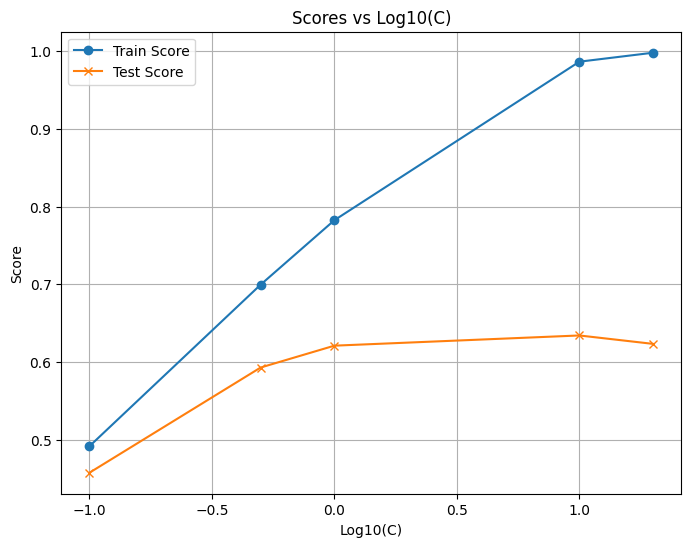

In [ ]:
# Training Logistic regression model and chekcing f1 score metric
C_values = [0.1, 0.5, 1, 10, 20]

# Set max_iter to a fixed value
fixed_max_iter = 3000

train_scores = np.zeros(len(C_values))
test_scores = np.zeros(len(C_values))

for j, C in enumerate(C_values):
    lr = LogisticRegression(max_iter=fixed_max_iter, C=C, n_jobs=-1, random_state=25)
    lr.fit(train_post, train_target)
    train_sc = f1_score(train_target, lr.predict(train_post), average='weighted')
    test_sc = f1_score(test_target, lr.predict(test_post), average='weighted')
    
    test_scores[j] = test_sc
    train_scores[j] = train_sc
    
    print('C =', C, 'Train Score', train_sc, 'Test Score', test_sc)

# Plot scores
plt.figure(figsize=(8, 6))
plt.plot(np.log10(C_values), train_scores, label='Train Score', marker='o')
plt.plot(np.log10(C_values), test_scores, label='Test Score', marker='x')

plt.xlabel('Log10(C)')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Scores vs Log10(C)')
plt.show()
     

In [ ]:
param_grid = {
    'C': np.arange(0.5, 20.5, 0.5)
}
# Create RandomizedSearchCV object
lr_rscv = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, n_iter=10, cv=5, random_state=25, n_jobs=-1)
lr_rscv.fit(train_post, train_target)
best_C = lr_rscv.best_params_['C']
best_lr = LogisticRegression(max_iter=fixed_max_iter, C=best_C, n_jobs=-1, random_state=25)
best_lr.fit(train_post, train_target)
y_train_pred = best_lr.predict(train_post)
y_test_pred = best_lr.predict(test_post)
best_train_score_weighted = f1_score(train_target, y_train_pred, average='weighted')
best_test_score_weighted = f1_score(test_target, y_test_pred, average='weighted')

print("Best parameter: C =", best_C)
print("Best train score (weighted average):", best_train_score_weighted)
print("Best test score (weighted average):", best_test_score_weighted)

Best parameter: C = 3.5
Best train score (weighted average): 0.9181726417451704
Best test score (weighted average): 0.6403521235544615


In [ ]:
print('test classification report \n',classification_report(test_target,best_lr.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       0.65      0.29      0.40        38
        ENFP       0.71      0.61      0.66       135
        ENTJ       0.61      0.37      0.46        46
        ENTP       0.61      0.54      0.57       137
        ESFJ       1.00      0.22      0.36         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       1.00      0.12      0.22         8
        ESTP       0.89      0.44      0.59        18
        INFJ       0.64      0.69      0.66       294
        INFP       0.64      0.81      0.72       366
        INTJ       0.60      0.64      0.62       218
        INTP       0.67      0.80      0.73       261
        ISFJ       0.67      0.36      0.47        33
        ISFP       0.86      0.46      0.60        54
        ISTJ       0.80      0.29      0.43        41
        ISTP       0.74      0.58      0.65        67

    accuracy                           0.65      17

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


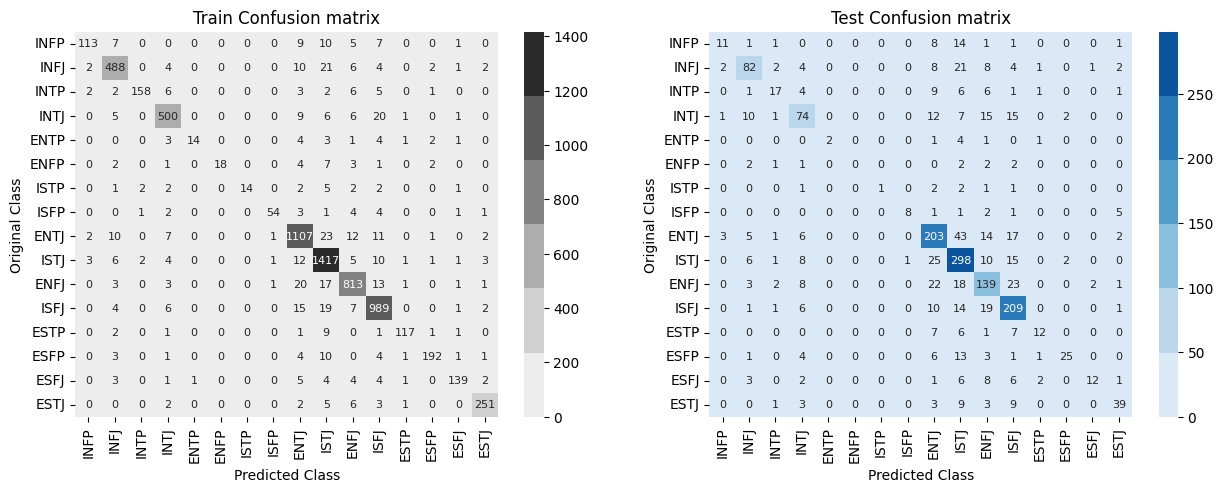

In [ ]:
confusion_matrices_plot(train_target,y_train_pred,test_target,y_test_pred,class_labels)

# Decision Tree

Depth =  3 Train Score 0.3614281211287419 test Score 0.35533181437521494
Depth =  10 Train Score 0.6745394379868049 test Score 0.5227157356735013
Depth =  15 Train Score 0.8305742730367354 test Score 0.50755774015795
Depth =  30 Train Score 0.9588258596300532 test Score 0.48909212748893865
Depth =  50 Train Score 0.9902817330464448 test Score 0.4767184184548214
Depth =  100 Train Score 1.0 test Score 0.48743637674149454


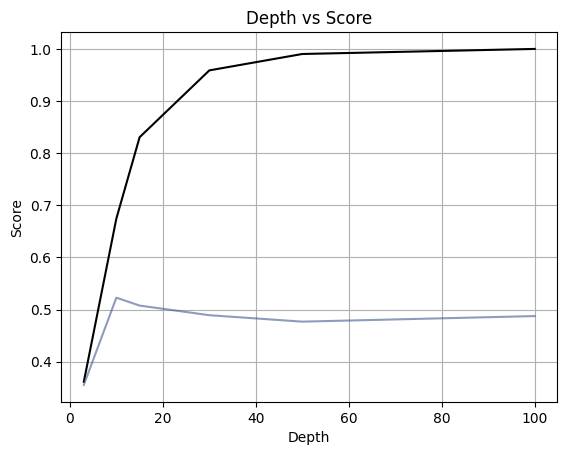

In [ ]:
# Checking the variation of score with depth parameters of Decision Tree
depth = [3,10,15,30,50,100]
train_scores = []
test_scores = []
for i in depth:
    clf = DecisionTreeClassifier(max_depth=i,random_state=25)
    clf.fit(train_post,train_target)
    train_sc = f1_score(train_target,clf.predict(train_post),average='weighted')
    test_sc = f1_score(test_target,clf.predict(test_post),average='weighted')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Depth = ',i,'Train Score',train_sc,'test Score',test_sc)


# plotting the score vs depth
plt.plot(depth,train_scores,label='Train Score',color='black')
plt.plot(depth,test_scores,label='Test Score',color='#425a90',alpha=0.6)
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs Score')
plt.grid()
plt.show()
     

In [ ]:
dt = DecisionTreeClassifier(random_state=25)

params = { "max_depth": sp_randint(15,30)}

random_cfl1 = RandomizedSearchCV(dt, param_distributions=params,verbose=10,scoring='f1_weighted',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(train_post,train_target)

best_params = random_cfl1.best_params_
dt_best = DecisionTreeClassifier(random_state=25, **best_params)
dt_best.fit(train_post, train_target)
y_train_pred = dt_best.predict(train_post)
y_test_pred = dt_best.predict(test_post)
best_train_score_weighted = f1_score(train_target, y_train_pred, average='weighted')
best_test_score_weighted = f1_score(test_target, y_test_pred, average='weighted')

print("Best parameter: ", best_params)
print("Best train score (weighted average):", best_train_score_weighted)
print("Best test score (weighted average):", best_test_score_weighted)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameter:  {'max_depth': 17}
Best train score (weighted average): 0.8666530363141461
Best test score (weighted average): 0.5117913812563168


In [ ]:
print('test classification report \n',classification_report(test_target,dt_best.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       0.08      0.03      0.04        38
        ENFP       0.47      0.46      0.47       135
        ENTJ       0.32      0.22      0.26        46
        ENTP       0.47      0.39      0.43       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.25      0.12      0.17         8
        ESTP       0.27      0.22      0.24        18
        INFJ       0.59      0.58      0.59       294
        INFP       0.53      0.70      0.60       366
        INTJ       0.56      0.48      0.52       218
        INTP       0.60      0.65      0.62       261
        ISFJ       0.46      0.33      0.39        33
        ISFP       0.41      0.28      0.33        54
        ISTJ       0.44      0.41      0.43        41
        ISTP       0.45      0.48      0.46        67

    accuracy                           0.52      17

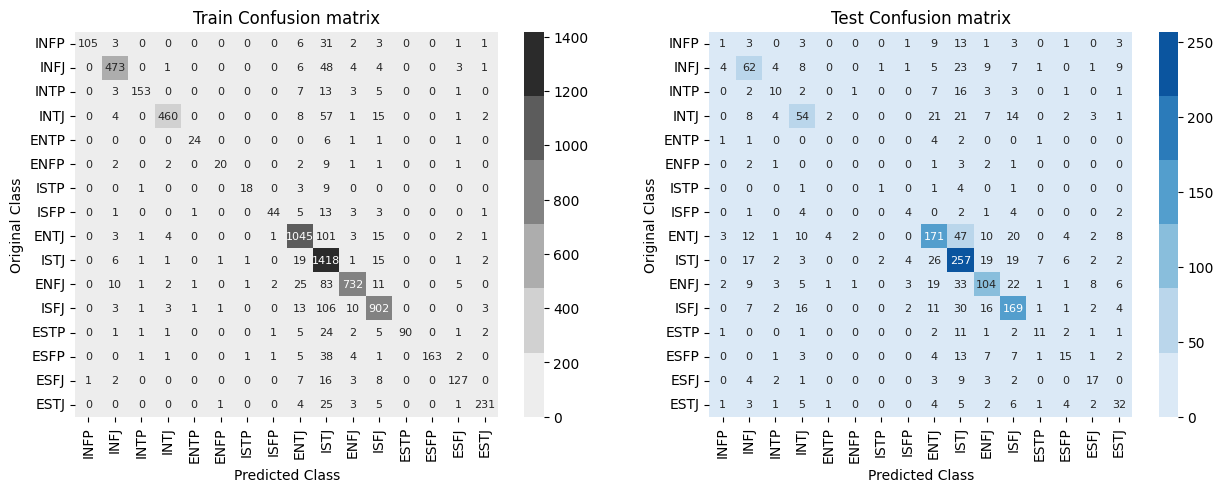

In [ ]:
confusion_matrices_plot(train_target,y_train_pred,test_target,y_test_pred,class_labels)

# Random forest

depth =  3 Train Score 0.217271912556022 test Score 0.2047592381608343
depth =  9 Train Score 0.542904229358254 test Score 0.3769112149481847
depth =  10 Train Score 0.6144767281114526 test Score 0.3869688957011674
depth =  15 Train Score 0.858426439952545 test Score 0.45852677145360093
depth =  20 Train Score 0.9629592249436749 test Score 0.48800090902566806
depth =  35 Train Score 0.9985565318660188 test Score 0.5064778212129049
depth =  50 Train Score 0.9998556704302435 test Score 0.513427540897508
depth =  70 Train Score 1.0 test Score 0.4989902933542248
depth =  130 Train Score 1.0 test Score 0.5115104421359334


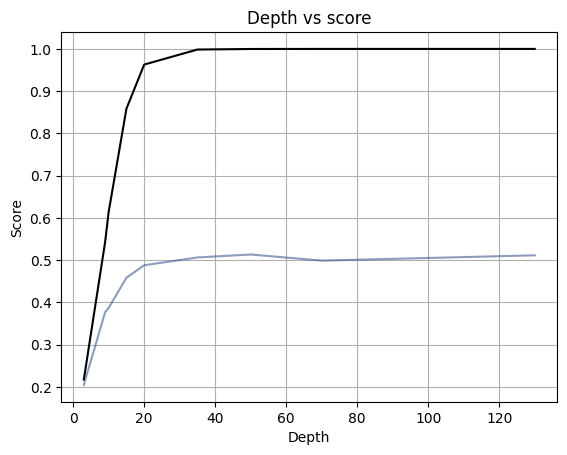

In [ ]:
depths = [3,9,10,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(criterion='gini', max_depth=i).fit(train_post, train_target)

    clf.fit(train_post,train_target)
    train_sc = f1_score(train_target,clf.predict(train_post),average='weighted')
    test_sc = f1_score(test_target,clf.predict(test_post),average='weighted')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score',color='black')
plt.plot(depths,test_scores,label='Test Score',color='#425a90',alpha=0.6)
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score')
plt.grid()
plt.show()

In [ ]:
params_dist = { "max_depth": sp_randint(70,130)}


clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=params_dist,
                                   n_iter=5,cv=10,scoring='f1_macro',random_state=25,return_train_score=True )

rf_random.fit(train_post,train_target)
best_params = rf_random.best_params_
rf_best = RandomForestClassifier(random_state=25, **best_params)
rf_best.fit(train_post, train_target)
y_train_pred = rf_best.predict(train_post)
y_test_pred = rf_best.predict(test_post)
best_train_score_weighted = f1_score(train_target, y_train_pred, average='weighted')
best_test_score_weighted = f1_score(test_target, y_test_pred, average='weighted')

print("Best parameter: ", best_params)
print("Best train score (weighted average):", best_train_score_weighted)
print("Best test score (weighted average):", best_test_score_weighted)

Best parameter:  {'max_depth': 74}
Best train score (weighted average): 1.0
Best test score (weighted average): 0.5092134055057852


In [ ]:
print('test classification report \n',classification_report(test_target,rf_best.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       1.00      0.08      0.15        38
        ENFP       0.72      0.36      0.48       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.59      0.40      0.48       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.55      0.72      0.62       294
        INFP       0.48      0.86      0.62       366
        INTJ       0.62      0.53      0.57       218
        INTP       0.63      0.75      0.68       261
        ISFJ       1.00      0.06      0.11        33
        ISFP       0.67      0.04      0.07        54
        ISTJ       1.00      0.02      0.05        41
        ISTP       0.81      0.25      0.39        67

    accuracy                           0.56      17

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


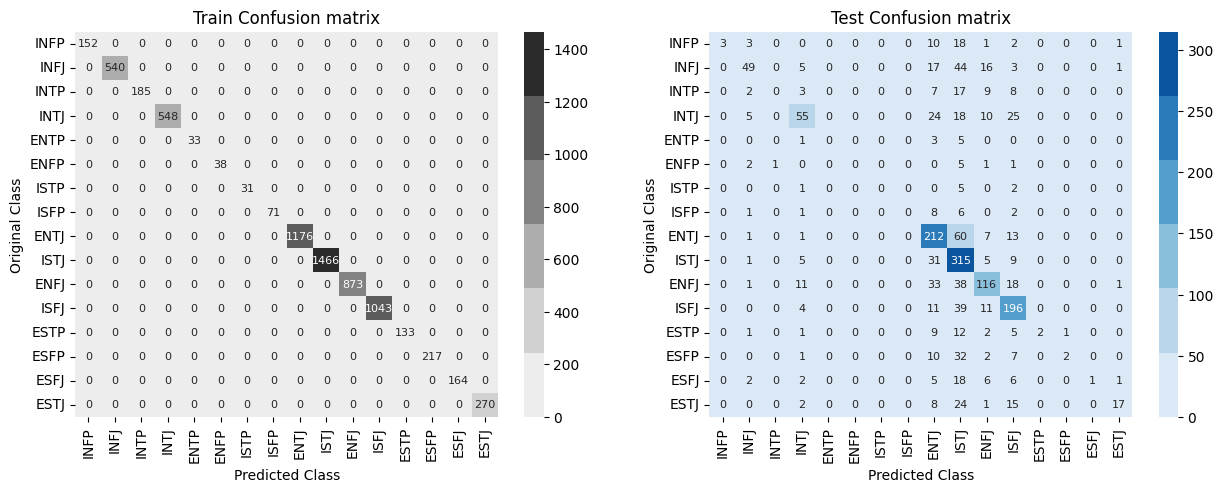

In [ ]:
confusion_matrices_plot(train_target,y_train_pred,test_target,y_test_pred,class_labels)

# XGBoost

In [ ]:
model_xgb=XGBClassifier(max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb.fit(train_post,train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
print('test classification report \n',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       0.56      0.37      0.44        38
        ENFP       0.72      0.61      0.66       135
        ENTJ       0.69      0.43      0.53        46
        ENTP       0.60      0.60      0.60       137
        ESFJ       1.00      0.11      0.20         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       1.00      0.38      0.55         8
        ESTP       0.46      0.33      0.39        18
        INFJ       0.69      0.71      0.70       294
        INFP       0.67      0.83      0.74       366
        INTJ       0.68      0.66      0.67       218
        INTP       0.67      0.79      0.72       261
        ISFJ       0.77      0.52      0.62        33
        ISFP       0.62      0.33      0.43        54
        ISTJ       0.74      0.41      0.53        41
        ISTP       0.64      0.58      0.61        67

    accuracy                           0.67      17

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


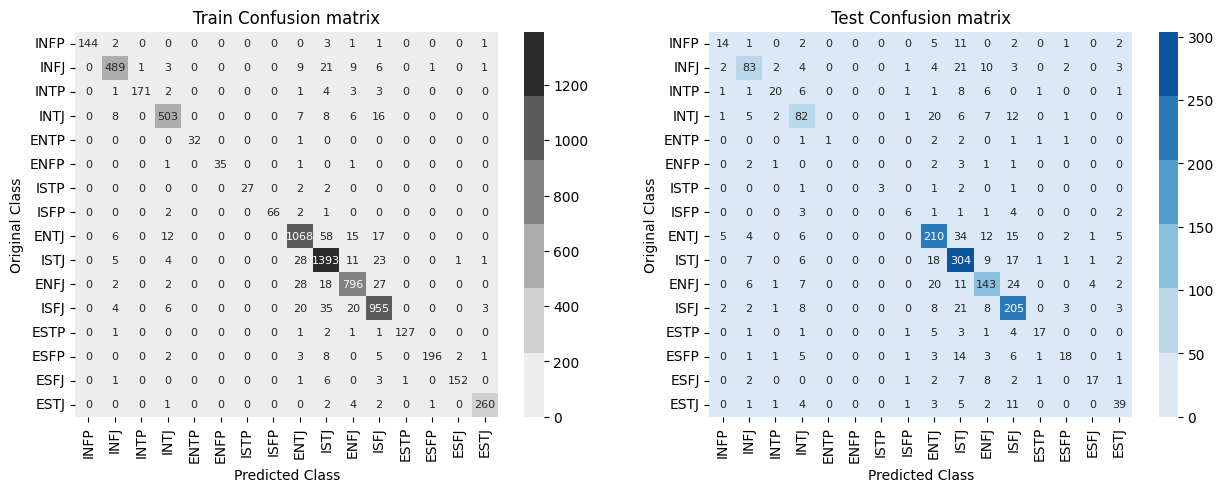

In [ ]:
confusion_matrices_plot(train_target,model_xgb.predict(train_post),test_target,model_xgb.predict(test_post),class_labels)

# LinearSVC

C = 0.1 Train Score 0.8203330182671867 Test Score 0.6463313541389483
C = 0.5 Train Score 0.9502178147804836 Test Score 0.6432599920503587
C = 1 Train Score 0.98054323225728 Test Score 0.6229435687439435
C = 10 Train Score 0.9998559177216282 Test Score 0.5570015204808091
C = 20 Train Score 1.0 Test Score 0.548830114380981


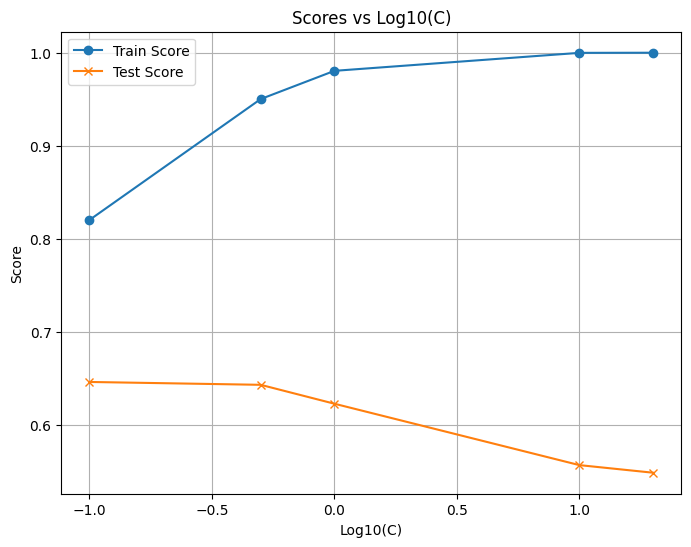

In [ ]:
# Training Logistic regression model and chekcing f1 score metric
C_values = [0.1, 0.5, 1, 10, 20]


train_scores = np.zeros(len(C_values))
test_scores = np.zeros(len(C_values))

for j, C in enumerate(C_values):
    lSVC = LinearSVC(C=C, random_state=25)
    lSVC.fit(train_post, train_target)
    train_sc = f1_score(train_target, lSVC.predict(train_post), average='weighted')
    test_sc = f1_score(test_target, lSVC.predict(test_post), average='weighted')
    
    test_scores[j] = test_sc
    train_scores[j] = train_sc
    
    print('C =', C, 'Train Score', train_sc, 'Test Score', test_sc)

# Plot scores
plt.figure(figsize=(8, 6))
plt.plot(np.log10(C_values), train_scores, label='Train Score', marker='o')
plt.plot(np.log10(C_values), test_scores, label='Test Score', marker='x')

plt.xlabel('Log10(C)')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Scores vs Log10(C)')
plt.show()
     

In [ ]:
linear_svc=LinearSVC()

param_grid = {
    'C': np.arange(0.1, 0.5, 0.1)
}
# Create RandomizedSearchCV object
lSVC = RandomizedSearchCV(estimator=linear_svc, param_distributions=param_grid, n_iter=5, cv=5, random_state=25, n_jobs=-1)
lSVC.fit(train_post, train_target)
best_C = lSVC.best_params_['C']
best_lSVC = LinearSVC(C=best_C,random_state=25)
best_lSVC.fit(train_post, train_target)
y_train_pred = best_lr.predict(train_post)
y_test_pred = best_lr.predict(test_post)
best_train_score_weighted = f1_score(train_target, y_train_pred, average='weighted')
best_test_score_weighted = f1_score(test_target, y_test_pred, average='weighted')

print("Best parameter: C =", best_C)
print("Best train score (weighted average):", best_train_score_weighted)
print("Best test score (weighted average):", best_test_score_weighted)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameter: C = 0.2
Best train score (weighted average): 0.8838789112546758
Best test score (weighted average): 0.6533894094485538


In [ ]:
print('test classification report \n',classification_report(test_target,best_lSVC.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       0.69      0.29      0.41        38
        ENFP       0.73      0.61      0.66       135
        ENTJ       0.65      0.43      0.52        46
        ENTP       0.62      0.54      0.58       137
        ESFJ       1.00      0.33      0.50         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       1.00      0.12      0.22         8
        ESTP       0.67      0.33      0.44        18
        INFJ       0.69      0.71      0.70       294
        INFP       0.64      0.85      0.73       366
        INTJ       0.62      0.66      0.64       218
        INTP       0.69      0.79      0.73       261
        ISFJ       0.67      0.42      0.52        33
        ISFP       0.81      0.46      0.59        54
        ISTJ       0.71      0.29      0.41        41
        ISTP       0.70      0.57      0.63        67

    accuracy                           0.67      17

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


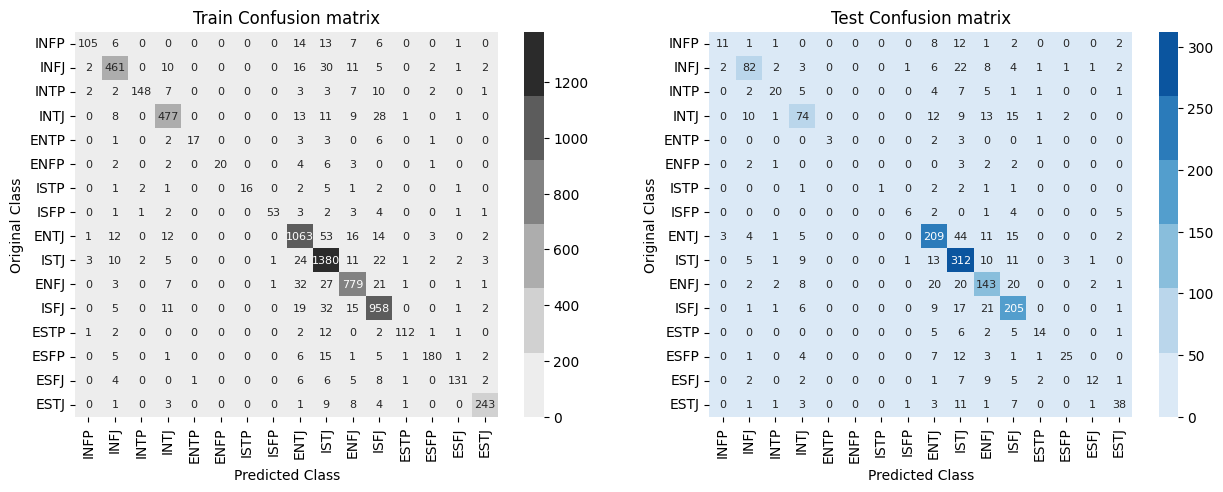

In [ ]:
confusion_matrices_plot(train_target,best_lSVC.predict(train_post),test_target,best_lSVC.predict(test_post),class_labels)